# Trabajo de caso real Arquitectura Big Data

Se trata de un conjunto de supermercados que tienen varios años de datos acumulados de productos de limpieza del hogar.
Realizan promociones de forma permanente y quieren poder predecir el volumen de ventas según las promociones que realizan.


### Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para visualizaciones
%matplotlib inline
sns.set(style="whitegrid")

### Cargamos los datos

In [2]:
locales = pd.read_csv('VMI_Locales-20190712.txt', sep='\t', encoding='ISO-8859-1', header=None)
movimientos = pd.read_csv('VMI_Movimientos-20190716.txt', sep='\t', encoding='ISO-8859-1', header=None)
promociones = pd.read_csv('VMI_Promociones-20190715.txt', sep='\t', encoding='ISO-8859-1', header=None)
prov_productos = pd.read_csv('VMI_ProvProdu-20190712.txt', sep='\t', encoding='ISO-8859-1', header=None)

In [3]:
locales.columns = ['ID Cadena', 'DescCadena', 'ID Region', 'DescRegion', 'ID Local/CD', 'DescLocal', 'Latitud', 'Longitud', 'PD']
movimientos.columns = ['ID Local/CD', 'ID producto', 'Fecha de la transaccion', 'Stock en unidades', 'Venta dia anterior en unidades', 'Precio de venta unitario', 'CD que abastece', 'RolLocal']
promociones.columns = ['ID Local/CD', 'ID producto', 'Fecha-desde', 'Fecha-Hasta', 'Total ventas en Unidades', 'Nro. Promocion', 'Fecha de la transaccion', 'Porc_Descuento']



## EDA Dataset Locales

Este conjunto de datos es una recopilación detallada de información sobre una red de locales y puntos de distribución (PD) pertenecientes a varias cadenas de supermercados. Cada entrada en el conjunto de datos incluye identificadores y descripciones tanto de la cadena de supermercados a la que pertenece el local o PD, como de la región geográfica donde se encuentra. Además, proporciona detalles específicos sobre la ubicación, incluyendo la latitud y longitud, lo que facilita el análisis geográfico. El indicador PD distingue entre locales comerciales (donde se realizan ventas directas a los consumidores) y puntos o centros de distribución (que sirven como nodos logísticos para el abastecimiento de los locales). 

In [4]:
locales.head()

,ID Cadena,DescCadena,ID Region,DescRegion,ID Local/CD,DescLocal,Latitud,Longitud,PD
0,1,Plaza Vea,1,Buenos Aires,9693,9693 - P Vea Villa Urquiza.,NaN,NaN,N
1,1,Plaza Vea,1,Buenos Aires,9694,9694 - P Vea JB Justo.,NaN,NaN,N
2,1,Plaza Vea,1,Buenos Aires,9695,695 - P Vea Acoyte.,0.0,0.0,N
3,1,Plaza Vea,1,Buenos Aires,9699,699 - P Vea Rivadavia.,0.0,0.0,N
4,1,Plaza Vea,1,Buenos Aires,9889,889 - Plaza Vea Carpa de liqui,NaN,NaN,N


Observamos que en la columna de Latitud y Longitud aparecen valores con 0.0, o con valores NaN.

In [5]:
locales.shape

(175, 9)

In [6]:
locales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID Cadena    175 non-null    int64  
 1   DescCadena   175 non-null    object 
 2   ID Region    175 non-null    int64  
 3   DescRegion   175 non-null    object 
 4   ID Local/CD  175 non-null    int64  
 5   DescLocal    175 non-null    object 
 6   Latitud      140 non-null    float64
 7   Longitud     140 non-null    float64
 8   PD           175 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 12.4+ KB


Comprobamos el número de valores NaN y 0.0

In [7]:
locales.isnull().sum()

ID Cadena       0
DescCadena      0
ID Region       0
DescRegion      0
ID Local/CD     0
DescLocal       0
Latitud        35
Longitud       35
PD              0
dtype: int64

In [8]:
# Detectando locales con latitud y longitud NaN
locales_con_nan = locales[locales['Latitud'].isna() & (locales['Longitud'].isna())]

locales_con_nan

,ID Cadena,DescCadena,ID Region,DescRegion,ID Local/CD,DescLocal,Latitud,Longitud,PD
0,1,Plaza Vea,1,Buenos Aires,9693,9693 - P Vea Villa Urquiza.,NaN,NaN,N
1,1,Plaza Vea,1,Buenos Aires,9694,9694 - P Vea JB Justo.,NaN,NaN,N
4,1,Plaza Vea,1,Buenos Aires,9889,889 - Plaza Vea Carpa de liqui,NaN,NaN,N
7,2,Disco,1,Buenos Aires,285,953 - Venado Tuerto,NaN,NaN,N
9,2,Disco,1,Buenos Aires,961,961 - Av. Santa F,NaN,NaN,N
10,2,Disco,1,Buenos Aires,1190,6190 - BT SAF (Importaciones).,NaN,NaN,S
11,2,Disco,1,Buenos Aires,1914,3914 - Interno SLL BsAs 217.,NaN,NaN,S
67,4,Vea,1,Buenos Aires,248,917 - Mataderos II,NaN,NaN,N
69,4,Vea,1,Buenos Aires,250,168 - Lope de Vega,NaN,NaN,N
71,4,Vea,1,Buenos Aires,255,995 - Alvarez Jonte,NaN,NaN,N


In [9]:
locales.eq(0.0).sum()

ID Cadena       0
DescCadena      0
ID Region       0
DescRegion      0
ID Local/CD     0
DescLocal       0
Latitud        14
Longitud       14
PD              0
dtype: int64

Observamos que hay 14 locales con la latitud y longitud en 0.0. más 35 locales con la latitud y longitud con valor NaN. De 175 locales. 

In [10]:
# Detectando locales con latitud y longitud en 0.0
locales_con_cero = locales[(locales['Latitud'] == 0) & (locales['Longitud'] == 0)]

locales_con_cero

,ID Cadena,DescCadena,ID Region,DescRegion,ID Local/CD,DescLocal,Latitud,Longitud,PD
2,1,Plaza Vea,1,Buenos Aires,9695,695 - P Vea Acoyte.,0.0,0.0,N
3,1,Plaza Vea,1,Buenos Aires,9699,699 - P Vea Rivadavia.,0.0,0.0,N
16,2,Disco,1,Buenos Aires,9007,7 - Pte. Per¢n.,0.0,0.0,N
55,2,Disco,1,Buenos Aires,9205,205 - Carniceria Central.,0.0,0.0,N
63,2,Disco,1,Buenos Aires,9639,639 - Pinocho VII.,0.0,0.0,N
70,4,Vea,1,Buenos Aires,252,983 - Miramar,0.0,0.0,N
80,4,Vea,1,Buenos Aires,674,674 - Resistencia,0.0,0.0,N
134,9,Jumbo,1,Buenos Aires,305,305 - DEPOSITO CBN GROUP,0.0,0.0,S
153,9,Jumbo,1,Buenos Aires,5276,5276 - Jumbo Arenales,0.0,0.0,N
155,9,Jumbo,1,Buenos Aires,5299,5299 - Dep¢sito Tortuguitas,0.0,0.0,S


In [11]:
locales_con_coordenadas = locales[(locales['Latitud'].notna()) & (locales['Latitud'] != 0) &
                                   (locales['Longitud'].notna()) & (locales['Longitud'] != 0)]
locales_con_coordenadas

,ID Cadena,DescCadena,ID Region,DescRegion,ID Local/CD,DescLocal,Latitud,Longitud,PD
5,2,Disco,1,Buenos Aires,247,916 - SM 916 Gorostiaga,-34.565259,-58.436583,N
6,2,Disco,1,Buenos Aires,257,61 - Tortuguitas,-34.446043,-58.745098,N
8,2,Disco,1,Buenos Aires,740,740 - Canning,-34.853221,-58.502247,N
12,2,Disco,1,Buenos Aires,9001,1 - San Isidro.,-34.471531,-58.515350,N
13,2,Disco,1,Buenos Aires,9002,2 - Talcahuano.,-34.596256,-58.385701,N
...,...,...,...,...,...,...,...,...,...
151,9,Jumbo,1,Buenos Aires,5263,5263 - Jumbo Juan B. Justo,-34.609829,-58.465505,N
154,9,Jumbo,1,Buenos Aires,5277,5277 - Jumbo-Comodoro,-45.872649,-67.496036,N
159,9,Jumbo,1,Buenos Aires,5626,5626 - Jumbo Pacheco Novo,-34.453186,-58.630924,N
160,9,Jumbo,1,Buenos Aires,5961,5961 - Jumbo Av. Santa F,-34.577317,-58.428886,N


A continuación vamos a ver si existen datos duplicados.

In [12]:
# Contar duplicados basados en 'ID Local/CD'
duplicados = locales.duplicated(subset='ID Local/CD', keep=False).sum()
print(f'Número de duplicados basados en ID Local/CD: {duplicados}')


Número de duplicados basados en ID Local/CD: 0


In [13]:
# Contar duplicados basados en 'DescLocal'
duplicados = locales.duplicated(subset='DescLocal', keep=False).sum()
print(f'Número de duplicados basados en DescLocal: {duplicados}')

Número de duplicados basados en DescLocal: 0


En la columna PD he detectado que tiene valor 'N' y 'S' teniendo en cuenta la documentación, los valores nos están indicando con una N que NO es un Punto de distribución y con una S que SI es un Punto de distribución..

In [14]:
locales['PD'].unique()

array(['N', 'S'], dtype=object)

In [15]:
locales['PD'].value_counts()

PD
N    169
S      6
Name: count, dtype: int64

Después de realizar un conteo, observamos que hay 6 locales que SI son un punto de Distribución y el resto no lo son.

#### Estadísticas descriptivas 

In [16]:
locales.describe()

,ID Cadena,ID Region,ID Local/CD,Latitud,Longitud
count,175.000000,175.0,175.000000,140.000000,140.000000
mean,4.502857,1.0,6909.617143,-31.533832,-52.839588
std,2.945627,0.0,3421.539461,10.718891,17.724343
min,1.000000,1.0,242.000000,-45.872649,-67.496036
25%,2.000000,1.0,5213.500000,-34.730633,-58.632039
50%,4.000000,1.0,9019.000000,-34.601654,-58.434434
75%,4.000000,1.0,9158.500000,-34.546212,-58.251974
max,11.000000,1.0,9977.000000,0.000000,0.000000


Si analizamos observamos que en el rango ID Cadena hay al menos 11 cadenas diferentes. En cuanto a la ID Region, es 1 esto nos indica que limitamos el análisis geográfico en una sola área en este caso la ciudad de Buenos aires. En cuanto el ID Local  varia considerablemente, nos muestra una gran diversidad de locales.
ya sabemos que en las columnas Latitud y Longitud tienen un rango de conteo menor 140 de 175 entradas totales, nos corrobora que existen valores faltantes. Un dato interesante es que las coordenadas promedio de latitud (-31.53) y longitud (-52.84) podrían indicar una concentración de datos en una región geográfica específica, probablemente en el sur del hemisferio occidental, considerando los valores negativos.

Conclusiones clave:  
  
**Diversidad de Cadenas:** El dataset representa una variedad de cadenas, aunque con una concentración en ciertos ID de cadena más que en otros.  
**Foco Regional Único:** Todos los datos pertenecen a la misma región, lo que limita el análisis regional pero ofrece una visión profunda de esta área específica.  
**Amplia Variedad de Locales:** Hay una amplia gama de locales representados, aunque algunos ID de locales son mucho más comunes.  
**Posibles Inexactitudes Geográficas:** Los valores faltantes y los datos geográficos atípicos (como los valores de 0.00) sugieren la necesidad de una limpieza de datos adicional para análisis geográficos precisos.

#### Análisis de Valores Únicos y Distribución de Categorías

In [17]:
# Valores únicos por columna categórica
columnas_categoricas = ['ID Cadena', 'DescCadena', 'ID Region', 'DescRegion', 'ID Local/CD', 'DescLocal']
for columna in columnas_categoricas:
    print(f'Valores únicos en {columna}:', locales[columna].nunique())

# Distribución de las cadenas y regiones
print("\nDistribución de cadenas:")
print(locales['DescCadena'].value_counts())

print("\nDistribución de regiones:")
print(locales['DescRegion'].value_counts())


Valores únicos en ID Cadena: 5
Valores únicos en DescCadena: 5
Valores únicos en ID Region: 1
Valores únicos en DescRegion: 1
Valores únicos en ID Local/CD: 175
Valores únicos en DescLocal: 175

Distribución de cadenas:
DescCadena
Vea                               68
Disco                             61
Jumbo                             31
Rincon Jumbo                      10
Plaza Vea                          5
Name: count, dtype: int64

Distribución de regiones:
DescRegion
Buenos Aires                      175
Name: count, dtype: int64


Observamos una dominancia clara de Vea y Disco en la columna 'DescCadena' y en la columna 'DescRegion' en la ciudad de Buenos Aires. Solo existe un ID Region que es la ciudad de Buenos Aires.

Antes de realizar un análisis geográfico vamos a crear un subconjunto de nuestro dataset que solo incluya registros con valores de latitud y longitud disponibles. Esto nos permitirá visualizar y analizar la distribución geográfica sin imputar datos ni eliminar registros de el dataset original.

In [18]:
# Crear un subconjunto con registros que tienen información geográfica completa
locales_con_coordenadas = locales.dropna(subset=['Latitud', 'Longitud'])

#### Análisis Geográfico

In [19]:
import folium

# Crear un mapa centrado en las coordenadas medias del subconjunto, excluyendo los valores exactamente iguales a 0.0
mapa_locales = folium.Map(location=[locales_con_coordenadas[locales_con_coordenadas['Latitud'] != 0]['Latitud'].mean(), 
                                    locales_con_coordenadas[locales_con_coordenadas['Longitud'] != 0]['Longitud'].mean()], zoom_start=10)

# Añadir marcadores para cada local en el subconjunto, excluyendo aquellos con coordenadas 0.0
for idx, fila in locales_con_coordenadas.iterrows():
    if fila['Latitud'] != 0 and fila['Longitud'] != 0:  # Filtrar valores exactamente iguales a 0.0
        popup_text = f"ID Local/CD: {fila['ID Local/CD']}, Cadena: {fila['DescCadena']}\n"
        popup_text += f"Coordenadas: {fila['Latitud']:.5f}, {fila['Longitud']:.5f}"
        folium.Marker([fila['Latitud'], fila['Longitud']],
                      popup=popup_text).add_to(mapa_locales)

# Mostrar el mapa
mapa_locales



Este código creará marcadores rojos para aquellos locales que se encuentran fuera de los límites geográficos aproximados definidos para la provincia de Buenos Aires

In [20]:
import folium

# Supongamos unos límites geográficos ficticios para la provincia de Buenos Aires
limite_norte = -34.0
limite_sur = -41.0
limite_este = -56.0
limite_oeste = -63.0

# Crear el mapa centrado en un punto medio de la provincia de Buenos Aires
mapa_locales = folium.Map(location=[-37.5, -59.5], zoom_start=6)

# Filtrar y marcar locales que están fuera de estos límites
for idx, fila in locales_con_coordenadas.iterrows():
    lat = fila['Latitud']
    lon = fila['Longitud']
    if lat < limite_sur or lat > limite_norte or lon < limite_oeste or lon > limite_este:
        # Este local está fuera de la provincia de Buenos Aires
        popup_text = f"ID Local/CD: {fila['ID Local/CD']}, Cadena: {fila['DescCadena']}\n"
        popup_text += f"Coordenadas: {lat:.5f}, {lon:.5f}"
        folium.Marker([lat, lon], popup=popup_text, icon=folium.Icon(color='red')).add_to(mapa_locales)

# Mostrar el mapa
mapa_locales


Vamos a crear un listado de los locales que están fuera de la provincia de Buenos Aires, basándonos en un conjunto de límites geográficos aproximados 

In [21]:
# Definir los límites geográficos aproximados de la provincia de Buenos Aires
limite_norte = -34.0
limite_sur = -41.0
limite_este = -56.0
limite_oeste = -63.0

# Filtrar los locales que están fuera de los límites definidos y no son NaN o 0.0
locales_fuera_ba = locales_con_coordenadas[
    ((locales_con_coordenadas['Latitud'] != 0) & (locales_con_coordenadas['Longitud'] != 0)) &
    ((locales_con_coordenadas['Latitud'] < limite_sur) | 
     (locales_con_coordenadas['Latitud'] > limite_norte) | 
     (locales_con_coordenadas['Longitud'] < limite_oeste) | 
     (locales_con_coordenadas['Longitud'] > limite_este))
]

# Crear el listado con los locales fuera de la provincia de Buenos Aires, excluyendo 0.0 y NaN
listado_fuera_ba = locales_fuera_ba[['ID Local/CD', 'DescCadena', 'Latitud', 'Longitud']]

print(listado_fuera_ba)


     ID Local/CD                      DescCadena    Latitud   Longitud
76           430  Vea                            -32.946868 -60.636206
77           631  Vea                            -33.677926 -59.668511
79           669  Vea                            -33.899131 -60.576621
82           685  Vea                            -30.739331 -57.966514
83           686  Vea                            -33.010391 -58.526405
84           688  Vea                            -29.141976 -59.265382
85           691  Vea                            -29.715194 -57.088845
89           752  Vea                            -43.268800 -65.281627
91           854  Vea                            -31.384417 -58.020819
92          6943  Vea                            -31.755795 -60.496477
131         9706  Vea                            -42.768281 -65.037972
146         5218  Jumbo                          -32.909118 -60.683434
154         5277  Jumbo                          -45.872649 -67.496036


Detectamos 2 valores que se han "colado" la línea 79  ID Local/CD 669 DescCadena  Vea   -33.899131 -60.576621 y 77  ID Local/CD 631  Vea  DescCadena  -33.677926 -59.668511 Tenemos 11 valores con datos de ubicación erronea,es decir, que el ID Region está puesto como 1 y la DescRegion está puesto como Buenos Aires, cuando está fuera de la provincia de Buenos aires.

### Corrección de datos ID Region y DescRegion 

In [22]:
# Suponiendo que el ID y la descripción correctos de la región son 2 y "OtraRegión" respectivamente
# Actualizar ID Region y DescRegion para los locales fuera de Buenos Aires

# ID y Descripción de la región actualizados
id_region_correcto = 2
desc_region_correcta = "OtraRegión"

# Actualizar los registros
locales_fuera_ba.loc[:, 'ID Region'] = id_region_correcto
locales_fuera_ba.loc[:, 'DescRegion'] = desc_region_correcta

# Ahora, locales_fuera_ba tiene las columnas 'ID Region' y 'DescRegion' actualizadas
print(locales_fuera_ba[['ID Local/CD', 'DescCadena', 'Latitud', 'Longitud', 'ID Region', 'DescRegion']])


     ID Local/CD                      DescCadena    Latitud   Longitud  \
76           430  Vea                            -32.946868 -60.636206   
77           631  Vea                            -33.677926 -59.668511   
79           669  Vea                            -33.899131 -60.576621   
82           685  Vea                            -30.739331 -57.966514   
83           686  Vea                            -33.010391 -58.526405   
84           688  Vea                            -29.141976 -59.265382   
85           691  Vea                            -29.715194 -57.088845   
89           752  Vea                            -43.268800 -65.281627   
91           854  Vea                            -31.384417 -58.020819   
92          6943  Vea                            -31.755795 -60.496477   
131         9706  Vea                            -42.768281 -65.037972   
146         5218  Jumbo                          -32.909118 -60.683434   
154         5277  Jumbo               

In [23]:
# IDs de los locales a excluir de la lista de locales fuera de Buenos Aires, ya que están dentro de la provincia
ids_dentro_ba = [669, 631]

# Excluir estos locales del DataFrame 'locales_fuera_ba'
locales_fuera_ba_corregido = locales_fuera_ba[~locales_fuera_ba['ID Local/CD'].isin(ids_dentro_ba)]

# Mostrar el DataFrame corregido
print(locales_fuera_ba_corregido)

     ID Cadena                      DescCadena  ID Region  DescRegion  \
76           4  Vea                                     2  OtraRegión   
82           4  Vea                                     2  OtraRegión   
83           4  Vea                                     2  OtraRegión   
84           4  Vea                                     2  OtraRegión   
85           4  Vea                                     2  OtraRegión   
89           4  Vea                                     2  OtraRegión   
91           4  Vea                                     2  OtraRegión   
92           4  Vea                                     2  OtraRegión   
131          4  Vea                                     2  OtraRegión   
146          9  Jumbo                                   2  OtraRegión   
154          9  Jumbo                                   2  OtraRegión   

     ID Local/CD                 DescLocal    Latitud   Longitud PD  
76           430               430 - Funes -32.946868

#### Vamos a actualizar la información en el dataset original locales.

Este código recorre cada fila del DataFrame locales_fuera_ba, que contiene los locales identificados previamente como estando fuera de la provincia de Buenos Aires y que han sido corregidos para reflejar su correcta región (ID Region y DescRegion). Luego, busca esos mismos locales en el DataFrame original locales usando el ID Local/CD como clave y actualiza las columnas ID Region y DescRegion con los valores corregidos.

In [24]:
# Asumiendo que 'locales' es tu DataFrame original y 'locales_fuera_ba' contiene las correcciones

# Primero, actualizamos 'locales' con las correcciones hechas en 'locales_fuera_ba'
# Esto se hace buscando los mismos 'ID Local/CD' en 'locales' y actualizando las columnas correspondientes

for idx, row in locales_fuera_ba.iterrows():
    locales.loc[locales['ID Local/CD'] == row['ID Local/CD'], 'ID Region'] = row['ID Region']
    locales.loc[locales['ID Local/CD'] == row['ID Local/CD'], 'DescRegion'] = row['DescRegion']

# Verificar las correcciones para asegurarse de que se hayan aplicado correctamente
print(locales[locales['ID Local/CD'].isin(locales_fuera_ba['ID Local/CD'])])


     ID Cadena                      DescCadena  ID Region  DescRegion  \
76           4  Vea                                     2  OtraRegión   
77           4  Vea                                     2  OtraRegión   
79           4  Vea                                     2  OtraRegión   
82           4  Vea                                     2  OtraRegión   
83           4  Vea                                     2  OtraRegión   
84           4  Vea                                     2  OtraRegión   
85           4  Vea                                     2  OtraRegión   
89           4  Vea                                     2  OtraRegión   
91           4  Vea                                     2  OtraRegión   
92           4  Vea                                     2  OtraRegión   
131          4  Vea                                     2  OtraRegión   
146          9  Jumbo                                   2  OtraRegión   
154          9  Jumbo                              

In [25]:
locales['ID Region'].unique()

array([1, 2], dtype=int64)

In [26]:
locales['DescRegion'].unique()

array(['Buenos Aires                  ', 'OtraRegión'], dtype=object)

#### Análisis de Indicador PD

In [27]:
pd_counts = locales['PD'].value_counts(normalize=True) * 100
print(pd_counts)


PD
N    96.571429
S     3.428571
Name: proportion, dtype: float64


El análisis del indicador PD muestra claramente que una gran mayoría de los locales, aproximadamente el 96.57%, no son puntos de distribución (indicados como "N"), mientras que solo un pequeño porcentaje, alrededor del 3.43%, sí lo son (indicados como "S"). 

In [28]:
# Guardar el DataFrame en un archivo CSV
locales.to_csv('locales_clean.csv', index=False)

## EDA Dataset Movimientos

In [29]:
movimientos.head()

,ID Local/CD,ID producto,Fecha de la transaccion,Stock en unidades,Venta dia anterior en unidades,Precio de venta unitario,CD que abastece,RolLocal
0,242,228217,20160715,24.0,0.0,13.63,0,SI
1,242,228217,20160716,24.0,0.0,13.63,0,SI
2,242,228217,20160717,24.0,0.0,13.63,0,SI
3,242,228217,20160718,24.0,0.0,13.63,0,SI
4,242,228217,20160719,24.0,0.0,13.63,0,SI


In [30]:
movimientos.shape

(8347817, 8)

In [31]:
movimientos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8347817 entries, 0 to 8347816
Data columns (total 8 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   ID Local/CD                     int64  
 1   ID producto                     int64  
 2   Fecha de la transaccion         int64  
 3   Stock en unidades               float64
 4   Venta dia anterior en unidades  float64
 5   Precio de venta unitario        float64
 6   CD que abastece                 int64  
 7   RolLocal                        object 
dtypes: float64(3), int64(4), object(1)
memory usage: 509.5+ MB


Observamos que:  
1.'Venta día anterior en unidades' está en formato decimal en lugar de número entero.  
2.'Precio de venta unitario' tiene valores 0.0  
3.'Fecha de la transaccion' no está en formato fecha y además según documentación es 1 día menos que la fecha actual. 

### Cambiamos el formato de la columna 'Venta dia anterior en unidades' a formato número entero

In [32]:
movimientos['Venta dia anterior en unidades'] = movimientos['Venta dia anterior en unidades'].astype(int)

### Cambiamos el formato de la columna 'Fecha de la transaccion' a formato fecha


In [33]:
movimientos['Fecha de la transaccion'] = pd.to_datetime(movimientos['Fecha de la transaccion'], format='%Y%m%d', errors='coerce')


In [34]:
movimientos.dtypes

ID Local/CD                                int64
ID producto                                int64
Fecha de la transaccion           datetime64[ns]
Stock en unidades                        float64
Venta dia anterior en unidades             int32
Precio de venta unitario                 float64
CD que abastece                            int64
RolLocal                                  object
dtype: object

In [35]:
movimientos

,ID Local/CD,ID producto,Fecha de la transaccion,Stock en unidades,Venta dia anterior en unidades,Precio de venta unitario,CD que abastece,RolLocal
0,242,228217,2016-07-15,24.0,0,13.63,0,SI
1,242,228217,2016-07-16,24.0,0,13.63,0,SI
2,242,228217,2016-07-17,24.0,0,13.63,0,SI
3,242,228217,2016-07-18,24.0,0,13.63,0,SI
4,242,228217,2016-07-19,24.0,0,13.63,0,SI
...,...,...,...,...,...,...,...,...
8347812,9977,511326,2019-07-10,9.0,0,100.82,9217,SI
8347813,9977,511326,2019-07-11,9.0,0,100.82,9217,SI
8347814,9977,511326,2019-07-12,9.0,0,100.82,9217,SI
8347815,9977,511326,2019-07-13,9.0,0,100.82,9217,SI


Vamos a ordenar por 'Fecha de la transaccion' y 'ID Local/CD'

In [36]:
movimientos.sort_values(by=['Fecha de la transaccion', 'ID Local/CD'], inplace=True)

In [37]:
movimientos

,ID Local/CD,ID producto,Fecha de la transaccion,Stock en unidades,Venta dia anterior en unidades,Precio de venta unitario,CD que abastece,RolLocal
0,242,228217,2016-07-15,24.0,0,13.63,0,SI
1332,242,238239,2016-07-15,7.0,0,13.05,0,SI
2424,242,238241,2016-07-15,24.0,0,13.05,0,NO
2690,242,240911,2016-07-15,16.0,1,15.06,0,SI
3782,242,242231,2016-07-15,14.0,0,15.06,0,SI
...,...,...,...,...,...,...,...,...
8346392,9977,507527,2019-07-14,13.0,0,43.35,9217,SI
8346718,9977,507528,2019-07-14,12.0,0,145.10,9217,SI
8347068,9977,507832,2019-07-14,3.0,0,40.47,9217,SI
8347318,9977,511324,2019-07-14,4.0,0,100.82,9217,SI


In [38]:
movimientos.isnull().sum()

ID Local/CD                       0
ID producto                       0
Fecha de la transaccion           0
Stock en unidades                 0
Venta dia anterior en unidades    0
Precio de venta unitario          0
CD que abastece                   0
RolLocal                          0
dtype: int64

In [39]:
movimientos.eq(0.0).sum()

ID Local/CD                             0
ID producto                             0
Fecha de la transaccion                 0
Stock en unidades                  657428
Venta dia anterior en unidades    6722807
Precio de venta unitario             9859
CD que abastece                   3425090
RolLocal                                0
dtype: int64

#### Estadística Descriptiva

In [40]:
movimientos.describe()

,ID Local/CD,ID producto,Fecha de la transaccion,Stock en unidades,Venta dia anterior en unidades,Precio de venta unitario,CD que abastece
count,8.347817e+06,8.347817e+06,8347817,8.347817e+06,8.347817e+06,8.347817e+06,8.347817e+06
mean,6.988555e+03,3.785489e+05,2018-02-28 23:47:52.156153344,2.065585e+01,3.133696e-01,6.426050e+01,5.435286e+03
min,2.420000e+02,1.641460e+05,2016-07-15 00:00:00,-5.420000e+02,-4.500000e+01,0.000000e+00,0.000000e+00
25%,5.208000e+03,2.929450e+05,2017-05-13 00:00:00,6.000000e+00,0.000000e+00,2.251000e+01,0.000000e+00
50%,9.026000e+03,4.152680e+05,2018-04-11 00:00:00,1.000000e+01,0.000000e+00,3.823000e+01,9.217000e+03
75%,9.159000e+03,4.583930e+05,2018-12-14 00:00:00,1.700000e+01,0.000000e+00,7.673000e+01,9.217000e+03
max,9.977000e+03,5.113260e+05,2019-07-14 00:00:00,1.621800e+04,6.120000e+02,4.238100e+02,9.217000e+03
std,3.300353e+03,9.159373e+04,NaN,1.488001e+02,8.950359e-01,6.582745e+01,4.533729e+03


**Tamaño del Dataset:** Hay 8,347,817 registros.  
  
**Rango de Fechas:** Las transacciones cubren un periodo desde el 15 de julio de 2016 hasta el 14 de julio de 2019, tenemos casi tres años de datos.  

**Stock en Unidades:** Los valores para el stock en unidades varían desde -542 hasta 16,218, con una media de aproximadamente 20.66 unidades. La presencia de valores negativos en el stock podría indicar devoluciones o errores en los datos que pueden requerir una investigación adicional.  

**Ventas del Día Anterior:** La mayoría de las ventas diarias anteriores son 0, con un promedio de aproximadamente 0.31 unidades y un máximo de 612 unidades. Esto sugiere que muchos productos no se venden cada día, pero hay casos excepcionales de altas ventas que podrían estar asociadas con promociones específicas o eventos.  

**Precio de Venta Unitario:** El precio varía de 0 a 423.81, con una media de 64.26. La presencia de precios unitarios de 0 podría indicar productos promocionales gratuitos, errores de datos o artículos específicos sin costo. Los precios muestran una amplia gama, lo que sugiere una diversa selección de productos.  

**CD que Abastece:** El Centro de Distribución (CD) que abastece tiene valores que van desde 0 hasta 9217, con una desviación estándar relativamente alta, lo que indica una gran variabilidad en el origen del abastecimiento de los productos.



#### Análisis de Tendencias Temporales

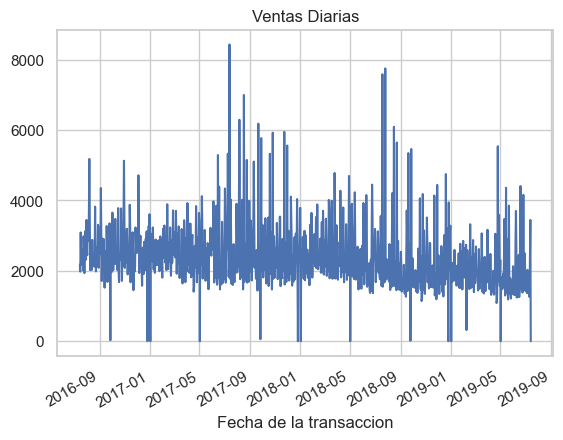

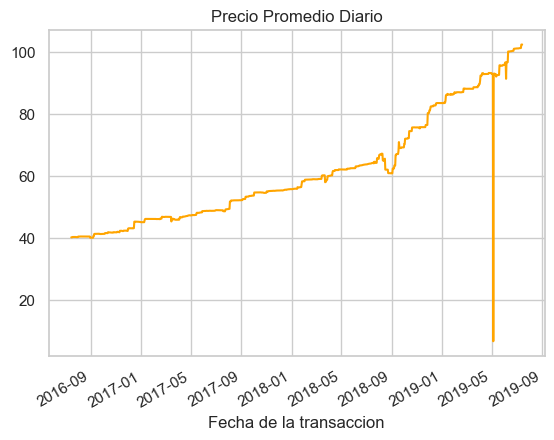

In [41]:
# Agrupar por fecha y calcular sumas de ventas y promedios de precio
ventas_diarias = movimientos.groupby('Fecha de la transaccion')['Venta dia anterior en unidades'].sum()
precios_promedio_diarios = movimientos.groupby('Fecha de la transaccion')['Precio de venta unitario'].mean()

# Graficar
ventas_diarias.plot(title='Ventas Diarias')
plt.show()

precios_promedio_diarios.plot(title='Precio Promedio Diario', color='orange')
plt.show()


Observamos el pico de bajada de la pandemia en 2019

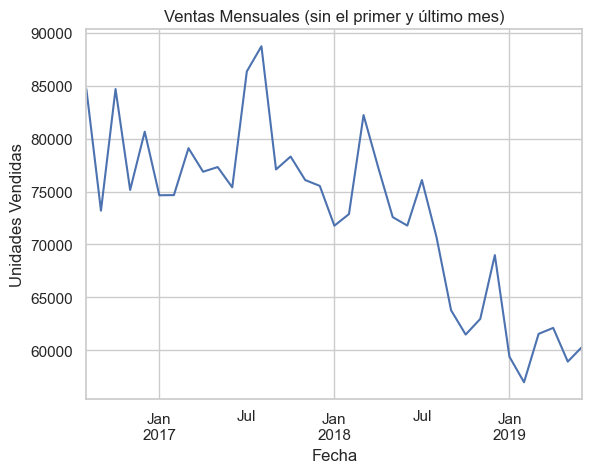

In [42]:
# Establecer la columna de fecha como el índice
movimientos.set_index('Fecha de la transaccion', inplace=True)

# Resumir las ventas diarias anteriores por mes
ventas_mensuales = movimientos.resample('M')['Venta dia anterior en unidades'].sum()

# Excluir el primer y último mes
ventas_mensuales_centrales = ventas_mensuales.iloc[1:-1]

# Graficar las ventas mensuales, excluyendo el primer y último mes
ventas_mensuales_centrales.plot(title='Ventas Mensuales (sin el primer y último mes)')
plt.ylabel('Unidades Vendidas')
plt.xlabel('Fecha')
plt.show()


Observamos que ha habido una caida importante de ventas a partir del febrero del 2018. Por otro lado, observamos en la gráfica anterior que el precio promedio diario ha aumentado en ese mismo periodo. 

#### Análisis de Descomposición Temporal

Descompone la serie temporal en tendencia, estacionalidad y residuo para identificar si la caída es parte de una tendencia a largo plazo o un evento puntual.

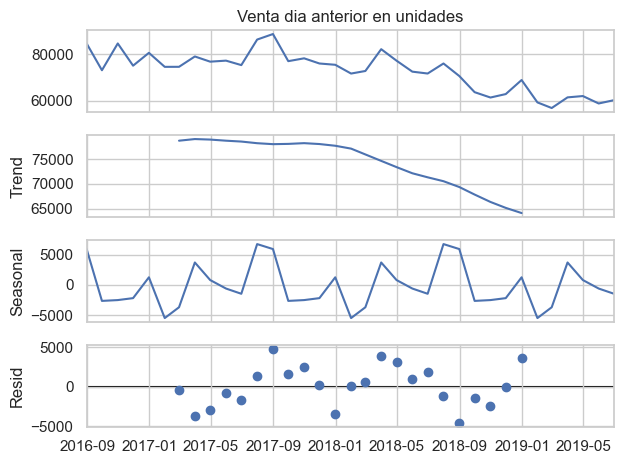

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie temporal
result = seasonal_decompose(ventas_mensuales_centrales, model='additive')
result.plot()
plt.show()


### Segmentación de Productos

In [44]:
movimientos.groupby('ID producto')['Venta dia anterior en unidades'].sum().sort_values(ascending=False).head(10)


ID producto
342686    109151
240911    100622
429883     89072
249486     86710
342745     72627
228217     68760
242234     67852
447299     66066
292949     64334
242231     61819
Name: Venta dia anterior en unidades, dtype: int32

## EDA Dataset Promociones

In [45]:
promociones.head()

,ID Local/CD,ID producto,Fecha-desde,Fecha-Hasta,Total ventas en Unidades,Nro. Promocion,Fecha de la transaccion,Porc_Descuento
0,242,228217,20161023,20161030,0.98,436830,20161005,7.0
1,242,228217,20161023,20161030,0.98,436830,20161006,7.0
2,242,228217,20161023,20161030,0.98,436830,20161007,7.0
3,242,228217,20161023,20161030,0.98,436830,20161008,7.0
4,242,228217,20161023,20161030,0.98,436830,20161009,7.0


In [46]:
promociones.shape

(285253, 8)

In [47]:
promociones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285253 entries, 0 to 285252
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID Local/CD               285253 non-null  int64  
 1   ID producto               285253 non-null  int64  
 2   Fecha-desde               285253 non-null  int64  
 3   Fecha-Hasta               285253 non-null  int64  
 4   Total ventas en Unidades  285253 non-null  float64
 5   Nro. Promocion            285253 non-null  int64  
 6   Fecha de la transaccion   285253 non-null  int64  
 7   Porc_Descuento            285253 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 17.4 MB


Observamos que:  
1.'Total ventas en Unidades' está en formato decimal en lugar de número entero.  
2. Fecha-desde',Fecha-Hasta' y 'Fecha de la transaccion' no están en formato fecha.  

#### Cambiamos el formato de la columna 'Total ventas en Unidades' a formato número entero


In [48]:
promociones['Total ventas en Unidades'] = promociones['Total ventas en Unidades'].astype(int)

#### Cambiamos el formato de la columna 'Fecha de la transaccion', 'Fecha-desde' y 'Fecha-Hasta' a formato fecha 

In [49]:
promociones['Fecha de la transaccion'] = pd.to_datetime(promociones['Fecha de la transaccion'], format='%Y%m%d', errors='coerce')

In [50]:
promociones['Fecha-desde'] = pd.to_datetime(promociones['Fecha-desde'], format='%Y%m%d', errors='coerce')

In [51]:
promociones['Fecha-Hasta'] = pd.to_datetime(promociones['Fecha-Hasta'], format='%Y%m%d', errors='coerce')

In [52]:
promociones.dtypes

ID Local/CD                          int64
ID producto                          int64
Fecha-desde                 datetime64[ns]
Fecha-Hasta                 datetime64[ns]
Total ventas en Unidades             int32
Nro. Promocion                       int64
Fecha de la transaccion     datetime64[ns]
Porc_Descuento                     float64
dtype: object

In [53]:
promociones

,ID Local/CD,ID producto,Fecha-desde,Fecha-Hasta,Total ventas en Unidades,Nro. Promocion,Fecha de la transaccion,Porc_Descuento
0,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-05,7.0
1,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-06,7.0
2,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-07,7.0
3,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-08,7.0
4,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-09,7.0
...,...,...,...,...,...,...,...,...
285248,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-17,7.0
285249,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-18,7.0
285250,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-19,7.0
285251,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-20,7.0


In [54]:
# Guardar el DataFrame en un archivo CSV
promociones.to_csv('promociones_clean.csv', index=False)

## EDA Dataset Prov_Productos

In [55]:
prov_productos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967


In [56]:
prov_productos.shape

(82, 18)

Observamos que la lectura de los datos ha sido incorrecta, ha puesto todos los datos en una única columna. Deberíamos de 
hacer una lectura de los datos y separarlos en las columnas correspondientes.

#### Primero vamos a reordenar la información de las columnas

1. Eliminamos la primera columna que no aporta nada. 

In [57]:
#eliminar columna 'ID Proveedor'
#prov_productos.drop(prov_productos.columns[0], axis=1, inplace=True)

In [58]:
prov_productos.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,1,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967


### Eliminamos la columna 0 y 11                 

In [59]:
prov_productos = prov_productos.drop(prov_productos.columns[[0, 11]], axis=1)


In [60]:
prov_productos.head(5)

,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17
0,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967


In [61]:
prov_productos.shape

(82, 16)

2. Renombramos las columnas

In [62]:
prov_productos.columns = [
    'ID Proveedor', 
    'Razon Social Proveedor', 
    'ID Seccion', 
    'Descripcion Seccion', 
    'ID Gran Familia', 
    'Descripcion Gran Familia', 
    'ID Familia', 
    'Descripcion Familia', 
    'ID Subfamilia', 
    'Descripcion Sub Familia',
    'Descripcion Articulo', 
    'ID Articulo',
    'ID Producto', 
    'Descripcion Producto', 
    'ID Región',
    'Ultima Fecha'  # Añadimos el nombre para la columna adicional que faltaba y que no está en los doc.
]

In [63]:
prov_productos.shape

(82, 16)

In [64]:
prov_productos.head(5)

,ID Proveedor,Razon Social Proveedor,ID Seccion,Descripcion Seccion,ID Gran Familia,Descripcion Gran Familia,ID Familia,Descripcion Familia,ID Subfamilia,Descripcion Sub Familia,Descripcion Articulo,ID Articulo,ID Producto,Descripcion Producto,ID Región,Ultima Fecha
0,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967


In [65]:
prov_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID Proveedor              82 non-null     int64 
 1   Razon Social Proveedor    82 non-null     object
 2   ID Seccion                82 non-null     int64 
 3   Descripcion Seccion       82 non-null     object
 4   ID Gran Familia           82 non-null     int64 
 5   Descripcion Gran Familia  82 non-null     object
 6   ID Familia                82 non-null     int64 
 7   Descripcion Familia       82 non-null     object
 8   ID Subfamilia             82 non-null     int64 
 9   Descripcion Sub Familia   82 non-null     object
 10  Descripcion Articulo      82 non-null     object
 11  ID Articulo               82 non-null     int64 
 12  ID Producto               82 non-null     int64 
 13  Descripcion Producto      82 non-null     object
 14  ID Región                 82

Observamos que la útlima columna 'Ultima Fecha' está en formato object, debería de ser en formato fecha.

In [66]:
prov_productos['Ultima Fecha'] = pd.to_datetime(prov_productos['Ultima Fecha'], errors='coerce')

In [67]:
prov_productos.dtypes

ID Proveedor                         int64
Razon Social Proveedor              object
ID Seccion                           int64
Descripcion Seccion                 object
ID Gran Familia                      int64
Descripcion Gran Familia            object
ID Familia                           int64
Descripcion Familia                 object
ID Subfamilia                        int64
Descripcion Sub Familia             object
Descripcion Articulo                object
ID Articulo                          int64
ID Producto                          int64
Descripcion Producto                object
ID Región                            int64
Ultima Fecha                datetime64[ns]
dtype: object

Comprobamos que se ha convertido correctamente la columna

In [68]:
prov_productos['Ultima Fecha'].isna()

0     False
1     False
2     False
3     False
4     False
      ...  
77    False
78    False
79    False
80    False
81    False
Name: Ultima Fecha, Length: 82, dtype: bool

In [69]:
prov_productos['Ultima Fecha']

0    2019-07-12 11:04:07.967
1    2019-07-12 11:04:07.967
2    2019-07-12 11:04:07.967
3    2019-07-12 11:04:07.967
4    2019-07-12 11:04:07.967
               ...          
77   2019-07-12 11:04:07.967
78   2019-07-12 11:04:07.967
79   2019-07-12 11:04:07.967
80   2019-07-12 11:04:07.967
81   2019-07-12 11:04:07.967
Name: Ultima Fecha, Length: 82, dtype: datetime64[ns]

In [70]:
prov_productos.isnull().sum()

ID Proveedor                0
Razon Social Proveedor      0
ID Seccion                  0
Descripcion Seccion         0
ID Gran Familia             0
Descripcion Gran Familia    0
ID Familia                  0
Descripcion Familia         0
ID Subfamilia               0
Descripcion Sub Familia     0
Descripcion Articulo        0
ID Articulo                 0
ID Producto                 0
Descripcion Producto        0
ID Región                   0
Ultima Fecha                0
dtype: int64

In [71]:
prov_productos

,ID Proveedor,Razon Social Proveedor,ID Seccion,Descripcion Seccion,ID Gran Familia,Descripcion Gran Familia,ID Familia,Descripcion Familia,ID Subfamilia,Descripcion Sub Familia,Descripcion Articulo,ID Articulo,ID Producto,Descripcion Producto,ID Región,Ultima Fecha
0,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4093,454775,POETT AMBIENTAL ESPIRITU JOVEN NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
78,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4094,455722,POETT AMBIENTAL DEJA VU NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
79,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4096,457746,POETT AMBIENTAL BOSQUE DE BAMBU NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
80,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4099,489517,POETT POETT AF360 LOVE EVOLUTION POETT AF360 L...,1,2019-07-12 11:04:07.967


In [72]:
prov_productos.duplicated().sum()

0

Guardamos en formato csv

In [73]:
# Guardar el DataFrame en un archivo CSV
prov_productos.to_csv('prov_productos_clean.csv', index=False)


In [74]:
locales

,ID Cadena,DescCadena,ID Region,DescRegion,ID Local/CD,DescLocal,Latitud,Longitud,PD
0,1,Plaza Vea,1,Buenos Aires,9693,9693 - P Vea Villa Urquiza.,NaN,NaN,N
1,1,Plaza Vea,1,Buenos Aires,9694,9694 - P Vea JB Justo.,NaN,NaN,N
2,1,Plaza Vea,1,Buenos Aires,9695,695 - P Vea Acoyte.,0.0,0.0,N
3,1,Plaza Vea,1,Buenos Aires,9699,699 - P Vea Rivadavia.,0.0,0.0,N
4,1,Plaza Vea,1,Buenos Aires,9889,889 - Plaza Vea Carpa de liqui,NaN,NaN,N
...,...,...,...,...,...,...,...,...,...
170,11,Rincon Jumbo,1,Buenos Aires,8306,8206 - Rinc¢n Palermo,NaN,NaN,N
171,11,Rincon Jumbo,1,Buenos Aires,8311,8211 - Rinc¢n Pilar,0.0,0.0,N
172,11,Rincon Jumbo,1,Buenos Aires,8314,8214 - Rinc¢n Escobar,NaN,NaN,N
173,11,Rincon Jumbo,1,Buenos Aires,8318,8218 - Rinc¢n Rosario,NaN,NaN,N


In [75]:
movimientos

,ID Local/CD,ID producto,Stock en unidades,Venta dia anterior en unidades,Precio de venta unitario,CD que abastece,RolLocal
Fecha de la transaccion,,,,,,,
2016-07-15,242,228217,24.0,0,13.63,0,SI
2016-07-15,242,238239,7.0,0,13.05,0,SI
2016-07-15,242,238241,24.0,0,13.05,0,NO
2016-07-15,242,240911,16.0,1,15.06,0,SI
2016-07-15,242,242231,14.0,0,15.06,0,SI
...,...,...,...,...,...,...,...
2019-07-14,9977,507527,13.0,0,43.35,9217,SI
2019-07-14,9977,507528,12.0,0,145.10,9217,SI
2019-07-14,9977,507832,3.0,0,40.47,9217,SI


In [76]:
promociones

,ID Local/CD,ID producto,Fecha-desde,Fecha-Hasta,Total ventas en Unidades,Nro. Promocion,Fecha de la transaccion,Porc_Descuento
0,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-05,7.0
1,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-06,7.0
2,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-07,7.0
3,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-08,7.0
4,242,228217,2016-10-23,2016-10-30,0,436830,2016-10-09,7.0
...,...,...,...,...,...,...,...,...
285248,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-17,7.0
285249,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-18,7.0
285250,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-19,7.0
285251,9977,474300,2016-08-16,2016-08-23,12,428910,2016-08-20,7.0


In [77]:
prov_productos

,ID Proveedor,Razon Social Proveedor,ID Seccion,Descripcion Seccion,ID Gran Familia,Descripcion Gran Familia,ID Familia,Descripcion Familia,ID Subfamilia,Descripcion Sub Familia,Descripcion Articulo,ID Articulo,ID Producto,Descripcion Producto,ID Región,Ultima Fecha
0,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27003,273920,REFILL CITRICO OIL ESCENCE AIR WICK CITRICOS ...,1,2019-07-12 11:04:07.967
1,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27004,273921,FRESHMATIC AIRWICK LAVANDA REPUESTO 250.00 MLT,1,2019-07-12 11:04:07.967
2,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27005,284012,AIR WICK CITRICO FULL REP.GRATIS AIR WICK AIR ...,1,2019-07-12 11:04:07.967
3,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27012,359572,MAGNOLIA Y CHERRY AIR WICK REPUESTO 175.00 GR,1,2019-07-12 11:04:07.967
4,252,Reckitt Benckiser Argentina S.A.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,27007,415268,FRESHMATIC BOSQUE MµGICO APARATO AIR WICK LUSH...,1,2019-07-12 11:04:07.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4093,454775,POETT AMBIENTAL ESPIRITU JOVEN NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
78,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4094,455722,POETT AMBIENTAL DEJA VU NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
79,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4096,457746,POETT AMBIENTAL BOSQUE DE BAMBU NUEVO D 0.377 KG,1,2019-07-12 11:04:07.967
80,1550,Clorox argentina s.a.,1,Almacn,4,Limpieza,3,Ba¤o y Hogar,4,Desodorantes de ambientes,Desodorantes en aerosol,4099,489517,POETT POETT AF360 LOVE EVOLUTION POETT AF360 L...,1,2019-07-12 11:04:07.967


## Visualizaciones

**Impacto General de las Promociones:** ¿Cuál es el impacto global de las promociones en el volumen de ventas de productos de limpieza del hogar?

In [84]:
# Obtener ventas de productos de limpieza del hogar durante promociones
ventas_during_promotions = movimientos[movimientos['ID producto'].isin(promociones['ID producto'])]['Stock en unidades'].sum()
print("Ventas de productos de limpieza del hogar durante promociones:", ventas_during_promotions)


Ventas de productos de limpieza del hogar durante promociones: 156383825.0


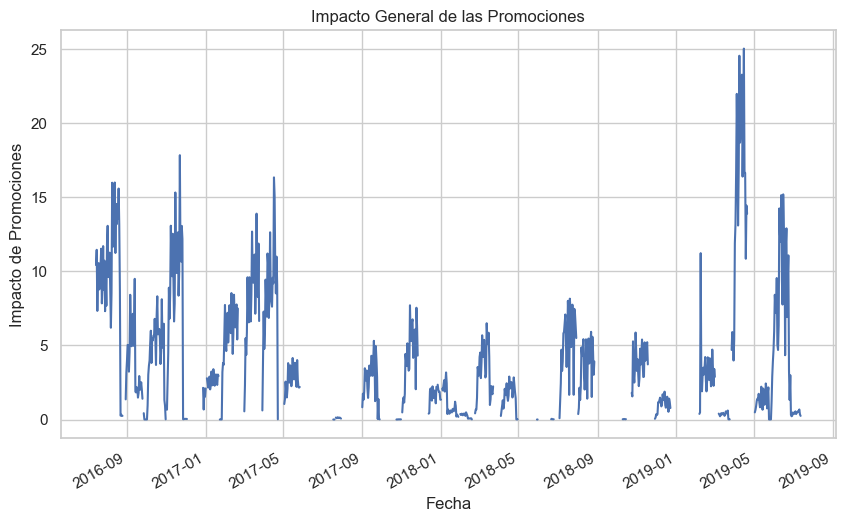

In [89]:
# Impacto General de las Promociones
promociones_por_fecha = promociones.groupby('Fecha de la transaccion')['Total ventas en Unidades'].sum()
ventas_totales = movimientos.groupby('Fecha de la transaccion')['Venta dia anterior en unidades'].sum()
impacto_promociones = promociones_por_fecha / ventas_totales

plt.figure(figsize=(10, 6))
impacto_promociones.plot()
plt.title('Impacto General de las Promociones')
plt.xlabel('Fecha')
plt.ylabel('Impacto de Promociones')
plt.show()

Efectividad de Tipos de Promociones

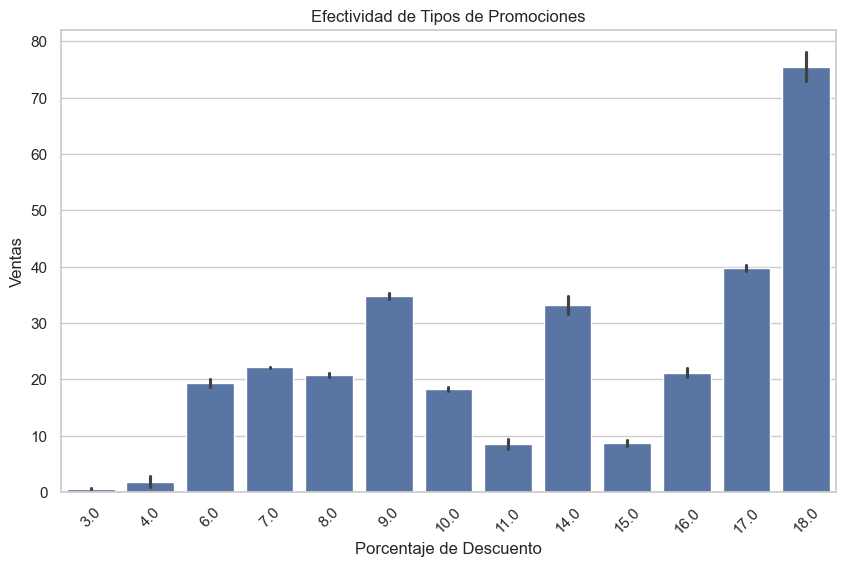

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Porc_Descuento', y='Total ventas en Unidades', data=promociones)
plt.title('Efectividad de Tipos de Promociones')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.show()

A mayor porcentaje de descuento, mayor es la efectividad de la promoción.

Temporalidad y Estacionalidad:

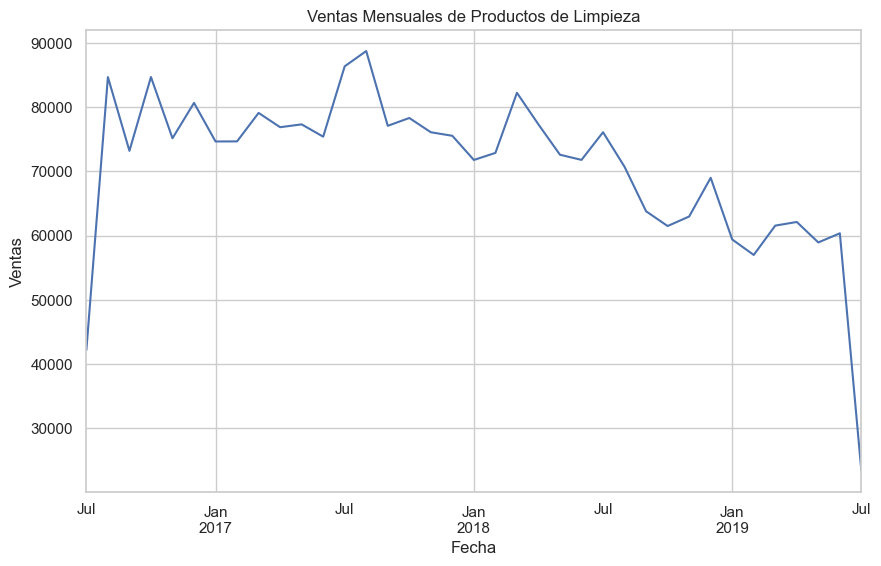

In [93]:
# Convertir la columna 'Fecha de la transaccion' a tipo datetime en cada DataFrame
promociones['Fecha de la transaccion'] = pd.to_datetime(promociones['Fecha de la transaccion'])
movimientos.index = pd.to_datetime(movimientos.index)

# Visualización del volumen de ventas a lo largo del tiempo
plt.figure(figsize=(10, 6))
movimientos.resample('M')['Venta dia anterior en unidades'].sum().plot()
plt.title('Ventas Mensuales de Productos de Limpieza')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()


Comparativa Entre Productos:

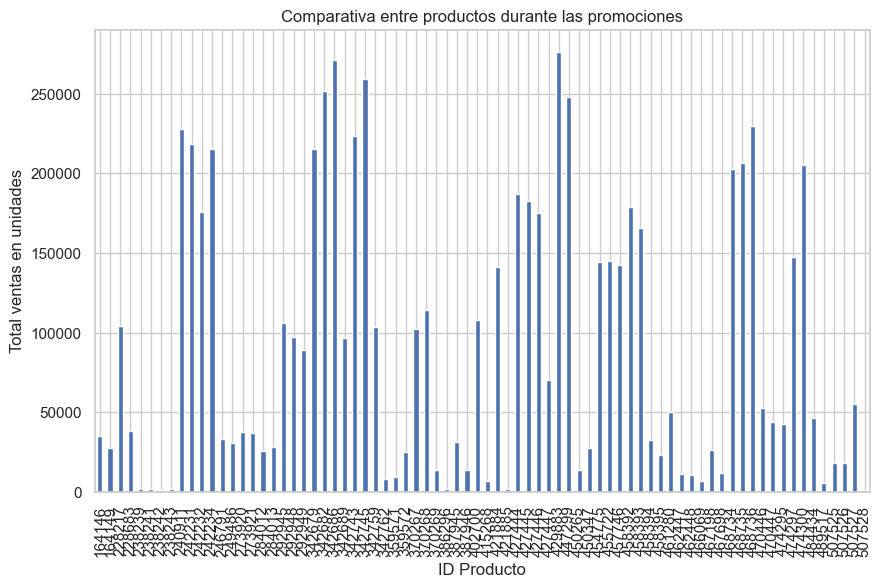

In [96]:
# Calcular las ventas por producto durante las promociones
ventas_por_producto = promociones.groupby('ID producto')['Total ventas en Unidades'].sum()

# Visualizar la comparativa entre productos
plt.figure(figsize=(10, 6))
ventas_por_producto.plot(kind='bar')
plt.title('Comparativa entre productos durante las promociones')
plt.xlabel('ID Producto')
plt.ylabel('Total ventas en unidades')
plt.grid(True)
plt.show()

Impacto de la Frecuencia Promocional:

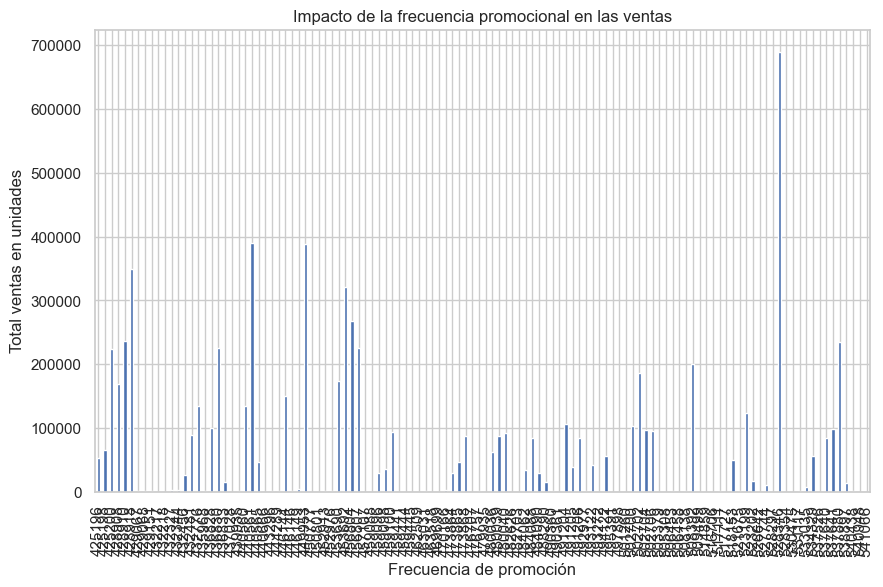

In [100]:
ventas_por_frecuencia = promociones.groupby('Nro. Promocion')['Total ventas en Unidades'].sum()

# Visualizar el impacto de la frecuencia promocional
plt.figure(figsize=(10, 6))
ventas_por_frecuencia.plot(kind='bar')
plt.title('Impacto de la frecuencia promocional en las ventas')
plt.xlabel('Frecuencia de promoción')
plt.ylabel('Total ventas en unidades')
plt.grid(True)
plt.show()

Aquí podemos observar que hay promociones que no tienen ventas. vamos a averiguar cuales son.

In [101]:
# Filtrar promociones que no generaron ventas
promociones_sin_ventas = promociones[promociones['Total ventas en Unidades'] == 0]

# Mostrar las promociones que no generaron ventas
print("Promociones que no generaron ventas:")
print(promociones_sin_ventas)


Promociones que no generaron ventas:
        ID Local/CD  ID producto Fecha-desde Fecha-Hasta  \
0               242       228217  2016-10-23  2016-10-30   
1               242       228217  2016-10-23  2016-10-30   
2               242       228217  2016-10-23  2016-10-30   
3               242       228217  2016-10-23  2016-10-30   
4               242       228217  2016-10-23  2016-10-30   
...             ...          ...         ...         ...   
284349         9973       450265  2019-03-30  2019-04-13   
284350         9973       450265  2019-03-30  2019-04-13   
284351         9973       450265  2019-03-30  2019-04-13   
284352         9973       450265  2019-03-30  2019-04-13   
284353         9973       450265  2019-03-30  2019-04-13   

        Total ventas en Unidades  Nro. Promocion Fecha de la transaccion  \
0                              0          436830              2016-10-05   
1                              0          436830              2016-10-06   
2             